# Unit Testing Optimisation

## Importing the Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use("pgf")
%matplotlib inline
plt.plot([1, 2, 3])
mpl.use("pgf")
mpl.rcParams.update(
    {
        "pgf.texsystem": "lualatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{bm}",
                r"\usepackage{mathtools}",
                r"\usepackage{amsmath}",
                r"\DeclarePairedDelimiter\abs{\lvert}{\rvert}%",
                r"\DeclarePairedDelimiter\norm{\lVert}{\rVert}",
                r"\makeatletter",
                r"\let\oldabs\abs",
                r"\def\abs{\@ifstar{\oldabs}{\oldabs*}}",
                r"\let\oldnorm\norm",
                r"\def\norm{\@ifstar{\oldnorm}{\oldnorm*}}",
                r"\makeatother",
                r"\usepackage[dvipsnames]{xcolor}", 
                r"\definecolor{myred}{RGB}{205, 108, 46}",
            ]
        ),
        "font.serif": ["Computer Modern Roman"],
    }
)

import matplotlib.font_manager
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size, make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax, value_and_grad, tree_multimap, tree_map

import time

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

## Defining SE Covariance

In [3]:
@jit
def AlpEnvelope(Xarr, TRise, TauDiff, Lag):
  TRise = TRise ** 2.0
  TDecay = TRise + TauDiff ** 2 + 1e-8
  TMax = (jnp.log(TRise / TDecay) * TDecay * TRise) / (TRise - TDecay)
  Max =  jnp.exp(- TMax / TDecay) - jnp.exp(- TMax / TRise)
  Delayed = Xarr - Lag
  NewTime = jnp.where(Delayed < 0.0, 1000, Delayed)
  return (jnp.exp(- NewTime / TDecay) - jnp.exp(- NewTime / TRise)) / Max

In [4]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

## Creating Test Data

In [5]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

In [6]:
# Time resolution
time_bin = 0.005

### Input Spike Train

In [7]:
subkeyx = subkeys[-1]

# Time horizon for input data
x_maxt = 12.0

# Maximum index of input data
k = np.floor(x_maxt/time_bin).astype(np.int64)

xtime = np.linspace(0.0, x_maxt, k + 1)

xtest = random.bernoulli(subkeyx, 0.1, (k+1,)).astype(np.float64)

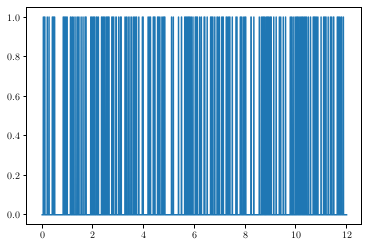

In [8]:
plt.plot(xtime, xtest)

### True Filter

In [26]:
subkeyf = subkeys[-2]

# Filter horizon
f_maxt = 1.0
f_start = -0.3
# Maximum index of filter data
n = np.floor(f_maxt/time_bin).astype(np.int64)
ftime = np.linspace(f_start, f_start + f_maxt, n + 1)

# Damped frequency
w_d = 18.0

# Sqrt True rise rate
tau_rise = np.sqrt(0.09)

# Sqrt True diff
tau_diff = np.sqrt(0.001)

# True lag
lag = 0.05

env_true = AlpEnvelope(ftime, tau_rise, tau_diff, lag)

# Envelope peak
sqtr = tau_rise ** 2
sqtd = sqtr + tau_diff ** 2
tmax = (np.log(sqtr / sqtd) * sqtd * sqtr) / (sqtr - sqtd)

ftrue = np.sin(w_d * (ftime - f_start - tmax - lag + np.pi/(2.0 * w_d))) * env_true

num_filt = 1

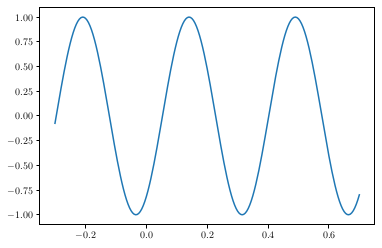

In [27]:
plt.plot(ftime, np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))))

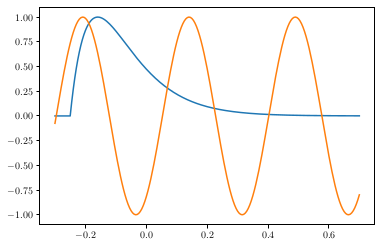

In [28]:
plt.plot(ftime, env_true)
plt.plot(ftime, np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))))

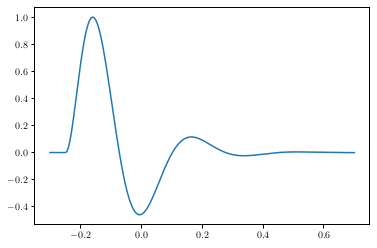

In [29]:
plt.plot(ftime, ftrue)

### True Noise

In [42]:
subkeyn = subkeys[-3]

# True noise variance
sign_true = 0.05

# Noise vector
noise_vec = sign_true * random.normal(subkeyn, (k + 1, 1))

### Output

In [43]:
# Padding and applying the FFT
xpad = np.vstack((xtest.reshape((k + 1, 1)), np.zeros((n, 1))))
fpad = np.vstack((ftrue.reshape((n + 1, 1)), np.zeros((k, 1))))

x_fft = np.fft.rfft(xpad, axis = 0)
f_fft = np.fft.rfft(fpad, axis = 0)

fftmul = x_fft * f_fft

ynonoise = np.fft.irfft(fftmul, n + k + 1, axis = 0)[:k + 1]

ytest = ynonoise + noise_vec
ytime = np.linspace(0.0, x_maxt, k + 1)

In [44]:
# Showing equals the raw convolution
yffttest = np.convolve(xtest, ftrue)[:k + 1] + noise_vec.flatten()

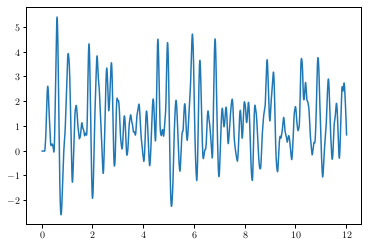

In [45]:
plt.plot(ytime, ynonoise)

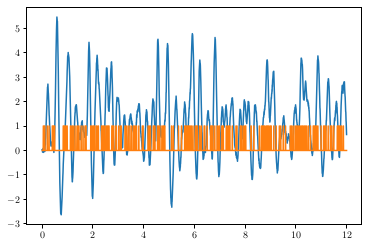

In [46]:
plt.plot(ytime, ytest)
plt.plot(xtime, xtest)

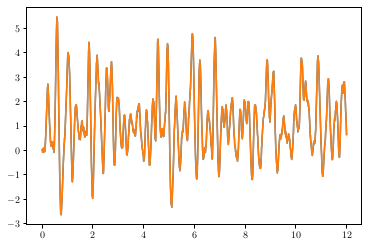

In [47]:
plt.plot(ytime, yffttest)
plt.plot(ytime, ytest)

## Variational Inference

### ELBO

#### Kl Divergence Term

In [48]:
@jit
def KL_Term(L_Matrix, V_Vector, M):
  return  0.5 * (- jnp.sum(jnp.log(jnp.diagonal(L_Matrix, axis1 = 1, axis2 = 2) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - M)

#### Expected Log-Likelihood

In [49]:
@jit
def Solver(Kmm, Diff):
  return jsc.linalg.solve(Kmm, Diff, sym_pos=True, check_finite=True)

In [50]:
V_Solver = vmap(Solver, in_axes = [None, 0])

In [51]:
@partial(jit, static_argnums = range(9,15))
def Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, TRise, TauDiff, Lag, Number_F, Num_Base,
                  M, Number_Filt, N, K, Y_Test, X_Fft, F_Time, Subkeys):

  Sigma_f_d = Sigma_f[:, :, None]
  Ell_f_d = Ell[:, :, None]
  TRise_d = TRise[:, :, None]
  TauDiff_d = TauDiff[:, :, None]

  Thetas = random.normal(Subkeys[0], (Number_F, Number_Filt, 1, Num_Base)) * (1.0 / Ell_f_d)

  Taus = random.uniform(Subkeys[1], (Number_F, Number_Filt, 1, Num_Base)) * 2.0 * jnp.pi

  Omegas = random.normal(Subkeys[2], (Number_F, Number_Filt, Num_Base, 1))

  Constant = (Sigma_f_d * jnp.sqrt(2.0 / Num_Base))

  ZT = Z_Vector.transpose(0, 2, 1)
 
  Phi1 = Constant * jnp.cos(F_Time * Thetas + Taus)
  Phi2 = Constant * jnp.cos(Z_Vector * Thetas + Taus)

  Kmm = Squared_exp(Z_Vector, ZT, Sigma_f_d, Ell_f_d)
  Knm = Squared_exp(F_Time, ZT, Sigma_f_d, Ell_f_d)

  C = jnp.linalg.cholesky(Kmm + jnp.eye(M) * 1e-6)

  V_u = C @ L_Matrix @ L_Matrix.transpose(0, 2, 1) @ C.transpose(0, 2, 1)

  Mu_u = C @ V_Vector

  V_uChol = jnp.linalg.cholesky(V_u + 1e-6 * jnp.eye(M))
  U_Samples = Mu_u + V_uChol @ random.normal(Subkeys[3], (Number_F, Number_Filt, M, 1))

  Vu = V_Solver(Kmm + 1e-6 * jnp.eye(M), U_Samples - Phi2 @ Omegas)

  F_Samples = (Phi1 @ Omegas + Knm @ Vu) * AlpEnvelope(F_Time, TRise_d, TauDiff_d, Lag)

  F_Samples = jnp.dstack((F_Samples, jnp.zeros((Number_F, Number_Filt, K, 1))))
  
  F_Fft = jnp.fft.rfft(F_Samples, axis = -2)

  Filter_Out = jnp.fft.irfft(F_Fft * X_Fft, N + K + 1, axis = -2)[:, :, : K + 1]

  Pred = jnp.sum(Filter_Out, axis = 1)
  
  Likelihoods = - 0.5 * ((K + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                    jnp.sum((Y_Test - Pred)**2, axis = 1)/(Sigma_n ** 2))
  
  return jnp.mean(Likelihoods)

In [52]:
test_number_f = 150
test_num_base = 100
test_m = int(1000)
test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 5)
test_sigma_f = 5.0 * np.ones((num_filt, 1))# np.arange(num_filt).reshape(1, num_filt, 1, 1)
test_ell_f = 2.0 * np.ones((num_filt, 1))
test_sigma_n = 0.05
test_z_m = np.tile(np.linspace(0.0, ftime[-1], test_m).reshape((test_m, 1)), (num_filt, 1, 1))
test_v_m = np.zeros(test_m * num_filt).reshape((num_filt, test_m, 1))
test_l_mm = np.tile(np.eye(test_m), (num_filt, 1, 1))
test_trise = 0.02 * np.ones((num_filt, 1))
test_tdiff = 0.03 * np.ones((num_filt, 1))
test_lag = 0.01 * np.ones((num_filt, 1))
xtest = xtest.reshape(1, k + 1, 1)
ftime = ftime.reshape(n + 1, 1)
print(xtest.shape)
print(ftime.shape)

(1, 2401, 1)
(201, 1)


In [53]:
samps = Expected_Term(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_mm, test_trise, test_tdiff, test_lag, test_number_f, test_num_base, test_m, num_filt, n, k, ytest, x_fft, ftime, test_subkeys)

In [54]:
print(samps)

-1491892.9563204227


#### ELBO

In [55]:
Diag = jit(vmap(jnp.diag, in_axes=[0,]))

In [56]:
@partial(jit, static_argnums = range(10, 16))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise, TauDiff, Lag, Number_F, Num_Base,
         M, Number_Filt, N, K, Indices, Y_Test, X_Fft, F_Time, Subkeys):
         
  Lag = Lag ** 2.0

  Lag_d = Lag[:, :, None]
  
  Z_Vector = (0.5 * jnp.sin( jnp.pi * (Z_Fractions - 0.5)) + 0.5) * (F_Time[-1, 0] - Lag_d) + Lag_d

  D = Diag(jnp.exp(L_Diag))

  L_Matrix = D.at[:, Indices[0], Indices[1]].set(L_ODiag)

  KL = KL_Term(L_Matrix, V_Vector, M)
  Exp = Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, TRise, TauDiff, Lag_d, Number_F, Num_Base,
                  M, Number_Filt, N, K, Y_Test, X_Fft, F_Time, Subkeys)
                  
  return (KL-Exp)/(K + 1)

In [57]:
test_number_f = 15
test_num_base = 100
test_m = int(3)
test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 5)
test_sigma_f = 2.0 * np.ones((num_filt, 1))# np.arange(num_filt).reshape(1, num_filt, 1, 1)
test_ell_f = 0.7 * np.ones((num_filt, 1))
test_sigma_n = 0.01
test_z_final = jnp.tile(jnp.linspace(0.0, 1.0, test_m).reshape((test_m, 1)), (num_filt, 1, 1))
test_z_m = (jnp.arcsin(2.0 * (test_z_final - 0.5)) / jnp.pi) + 0.5
test_v_m = 5.0 * np.ones((num_filt, test_m, 1))
test_l_diag = np.ones((num_filt, test_m))
test_l_odiag = np.tile(np.tril(np.ones((test_m, test_m)), -1)[np.tril_indices(test_m, -1)], (num_filt, 1))
test_trise = 0.02 * np.ones((num_filt, 1))
test_tdiff = 0.03 * np.ones((num_filt, 1))
test_lag = 0.01 * np.ones((num_filt, 1))
test_diagMat = Diag(test_l_diag)
test_indices = np.tril_indices(test_m, -1)
print(test_l_odiag.shape)
print(ftime.shape)

(1, 3)
(201, 1)


In [58]:
print(Neg_ELBO(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_diag, test_l_odiag, test_trise, test_tdiff, test_lag, test_number_f, test_num_base, test_m, num_filt, n, k, test_indices, ytest, x_fft, ftime, test_subkeys))

15210.892154378305


In [59]:
Grad_Bound = jit(value_and_grad(Neg_ELBO, argnums = range(10)), static_argnums = range(10, 16))

### Optimiser

#### Sub-function Definitions

In [60]:
@jit
def MCalc(Grad, M, B1 = 0.9):
  return (1 - B1) * Grad + B1 * M

In [61]:
@jit
def MBias(M, Step, B1 = 0.9):
  return M / (1 - B1 ** (Step + 1))

In [62]:
@jit
def VCalc(Grad, V, B2 = 0.99):
  return (1 - B2) * jnp.square(Grad) + B2 * V

In [63]:
@jit
def VBias(V, Step, B2 = 0.99):
  return V / (1 - B2 ** (Step + 1))

In [64]:
@jit
def CFinState(X, Mhat, Vhat, Step_Size = 1e-2, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [65]:
@jit
def MFinState(X, Mhat, Vhat, Step_Size = 1e-3, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [66]:
@jit
def FFinState(X, Mhat, Vhat, Step_Size = 1e-4, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [67]:
@jit
def CAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(CFinState, X, Mhat, Vhat)

  return X, M, V

In [68]:
@jit
def MAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(MFinState, X, Mhat, Vhat)

  return X, M, V

In [69]:
@jit
def FAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(FFinState, X, Mhat, Vhat)

  return X, M, V

In [70]:
@partial(jit, static_argnums = range(12,18))
def _CUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, Indices, Y_Test, X_Fft, F_Time,
             Num_Coarse_Fs, Num_Bases, M, Number_Filt, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, Num_Bases, M, Number_Filt, N, K, Indices, Y_Test, X_Fft, F_Time, Subkeys)
  X, Mad, Vad = CAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 5)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

In [71]:
@partial(jit, static_argnums = range(12,18))
def _MUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, Indices, Y_Test, X_Fft, F_Time,
             Num_Coarse_Fs, Num_Bases, M, Number_Filt, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, Num_Bases, M, Number_Filt, N, K, Indices, Y_Test, X_Fft, F_Time, Subkeys)
  X, Mad, Vad = MAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 5)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

In [72]:
@partial(jit, static_argnums = range(12,18))
def _FUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, Indices, Y_Test, X_Fft, F_Time,
             Num_Coarse_Fs, Num_Base, M, Number_Filt, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, Num_Base, M, Number_Filt, N, K, Indices, Y_Test, X_Fft, F_Time, Subkeys)
  X, Mad, Vad = FAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 5)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

#### Adam Function Definition

In [73]:
@partial(jit, static_argnums = range(5, 11))
def AdamOpt(Init_Params, X_Fft, Indices, Y_Test, F_Time, M, Number_Filt, N, K, Num_Fs, Num_Bases,              
                        Coarse_Schedule = jnp.asarray([400, 400, 700]), Mid_Schedule = jnp.asarray([16500]),
                        Fine_Iters = 2000):
  
  """
  Function implementing the Adam optimiser loop.
  """
  ELBO_History = jnp.zeros(20000)
  Step = 0
  Mad = tree_map(jnp.zeros_like, Init_Params)
  Vad = tree_map(jnp.zeros_like, Init_Params)
  Key = random.PRNGKey(0)
  Key, *Subkeys = random.split(Key, 5)
  Params = Init_Params

  def CUpdate(Iter, State):
    return _CUpdate(Iter, *State, Indices, Y_Test, X_Fft, F_Time, Num_Fs, Num_Bases, M, Number_Filt, N, K)

  def MUpdate(Iter, State):
    return _MUpdate(Iter, *State, Indices, Y_Test, X_Fft, F_Time, Num_Fs, Num_Bases, M, Number_Filt, N, K)

  def FUpdate(Iter, State):
    return _FUpdate(Iter, *State, Indices, Y_Test, X_Fft, F_Time, Num_Fs, Num_Bases, M, Number_Filt, N, K)

  JCUpdate = jit(CUpdate)
  JMUpdate = jit(MUpdate)
  JFUpdate = jit(FUpdate)

  def CReset(Iter, State):
    InOptState = lax.fori_loop(0, Coarse_Schedule[Iter], JCUpdate, State)
    return InOptState

  def MReset(Iter, State):
    InOptState = lax.fori_loop(0, Mid_Schedule[Iter], JMUpdate, State)
    return InOptState

  JCReset = jit(CReset)
  JMReset = jit(MReset)

  OptState = lax.fori_loop(0, len(Coarse_Schedule), JCReset, (Params, Subkeys, Key, ELBO_History, Step, Mad, Vad))

  OptState = lax.fori_loop(0, len(Mid_Schedule), JMReset, OptState)

  OptState = lax.fori_loop(0, Fine_Iters, JFUpdate, OptState)

  return OptState[0], OptState[-4]

In [74]:
key = random.PRNGKey(4)

# Initialising the parameters

# Generative parameters
isigma_f = 5.0 * jnp.ones((num_filt, 1))
iell = 0.002 * jnp.ones ((num_filt, 1))
isigma_n = 0.000005


itrise = np.sqrt(0.05) * jnp.ones((num_filt, 1))
itaudiff = np.sqrt(0.01) * jnp.ones((num_filt, 1))
ilag = np.sqrt(0.01) * jnp.ones((num_filt, 1))

# Variational parameters
num_ind = 20
iz_final = jnp.tile(jnp.linspace(0.0, 1.0, num_ind).reshape((num_ind, 1)), (num_filt, 1, 1))
iz_fracs = (jnp.arcsin(2.0 * (iz_final - 0.5)) / jnp.pi) + 0.5
key, *subkeys = random.split(key, 4)
iv_vector = jnp.tile((0.01 * random.normal(subkeys[-3], (num_ind,))).reshape((num_ind, 1)), (num_filt, 1, 1))
il_diag = jnp.tile(0.01 * random.normal(subkeys[-2], (num_ind,)), (num_filt, 1))
il_odiag = jnp.tile(0.1 * random.normal(subkeys[-1], (int((num_ind ** 2 - num_ind) / 2),)), (num_filt, 1))
num_f = 50
num_b = 100
ftimet =  ftime.reshape((n + 1, 1))
indices = jnp.tril_indices(num_ind, -1)

# Random number generator
opt_key = random.PRNGKey(1)
opt_key, *opt_subkey = random.split(opt_key, 5)

params = (isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag, il_odiag, itrise, itaudiff, ilag)
consparams = (num_ind, num_filt, n, k, indices, ytest, x_fft, ftimet)

In [75]:
fparams, elbo_history = AdamOpt(params, x_fft, indices, ytest, ftimet, num_ind, num_filt, n, k, num_f, num_b)

In [ ]:
# %%timeit
# fparams, elbo_history = AdamOpt(params, x_fft, ytest, ftime, ftimet, num_ind, n, k, num_f)

In [ ]:
print(Neg_ELBO(*params, num_f, num_b, *consparams, opt_subkey))

973846569125.9034


In [ ]:
print(Neg_ELBO(*fparams, num_f, num_b, *consparams, opt_subkey))
# -1.421189187

-1.5465108920562471


(1.0, 1.6)

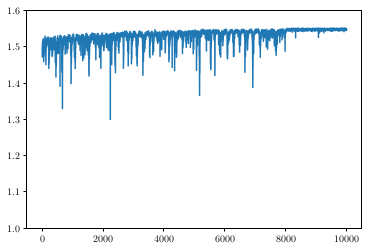

In [ ]:
plt.plot(elbo_history[10000:])
plt.ylim([1.0, 1.6])

In [ ]:
fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag, ftrise, ftaudiff, flag = fparams

In [ ]:
ilag = ilag ** 2

ilag_d = ilag[:, :, None]

iz_vector = (0.5 * np.sin( np.pi * (iz_fracs - 0.5)) + 0.5) * (ftime[-1, 0] - ilag_d) + ilag_d

idz = np.asarray(Diag(np.exp(il_diag)))
il_matrix = idz.copy()
il_matrix[:, indices[0], indices[1]] = il_odiag


flag = flag ** 2

flag_d = flag[:, :, None] 

fz_vector = (0.5 * np.sin( np.pi * (fz_fracs - 0.5)) + 0.5) * (ftime[-1] - flag_d) + flag_d

fd = np.asarray(Diag(np.exp(fl_diag)))
fl_matrix = fd.copy()
fl_matrix[:, indices[0], indices[1]] = fl_odiag

In [ ]:
print(fsigma_f)

[[3.43948561]]


In [ ]:
print(fell)

[[-0.10087592]]


In [ ]:
print(fsigma_n)

0.049941822493060714


In [ ]:
print(ftrise)

[[0.14069167]]


In [ ]:
print(ftaudiff)

[[0.26699154]]


In [ ]:
print(flag)

[[0.05319168]]


## Variational Predictions

In [ ]:
fpred_points = ftimet.copy()
ytime = ytime.reshape((k + 1, 1))

In [ ]:
isigma_f = isigma_f.reshape(num_filt, 1, 1)
iell = iell.reshape(num_filt, 1, 1)
itrise = itrise.reshape(num_filt, 1, 1)
itaudiff = itaudiff.reshape(num_filt, 1, 1)

fsigma_f = fsigma_f.reshape(num_filt, 1, 1)
fell = fell.reshape(num_filt, 1, 1)
ftrise = ftrise.reshape(num_filt, 1, 1)
ftaudiff = ftaudiff.reshape(num_filt, 1, 1)

In [ ]:
print(iz_vector.shape)

(1, 20, 1)


In [ ]:
ikmm = Squared_exp(iz_vector, iz_vector.transpose(0, 2, 1), isigma_f, iell)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Squared_exp(iz_vector, fpred_points.T, isigma_f, iell)
ibzast = np.zeros((num_filt, num_ind, n + 1))
ibzastT = ibzast.transpose(0, 2, 1)
for i in range(num_filt):
  ibzast[i] = sc.linalg.solve_triangular(icpred[i], ikzast[i], lower = True)
ipredenv = AlpEnvelope(fpred_points, itrise, itaudiff, ilag)
ipredenvT = ipredenv.transpose(0, 2, 1)
imeanpred = ipredenv * (ibzastT @ iv_vector)

ikastast = Squared_exp(fpred_points, fpred_points.T, isigma_f, iell)
icovpred = ipredenv * (ikastast + ibzastT @ (il_matrix @ il_matrix.transpose(0, 2, 1) - np.eye(num_ind)) @ ibzast) * ipredenvT

In [ ]:
fkmm = Squared_exp(fz_vector, fz_vector.transpose(0, 2 ,1), fsigma_f, fell)
fcpred = np.linalg.cholesky(fkmm + 1e-6 * np.eye(num_ind))
fkzast = Squared_exp(fz_vector, fpred_points.T, fsigma_f, fell)
fbzast = np.zeros((num_filt, num_ind, n + 1))
fbzastT = fbzast.transpose(0, 2, 1)
for i in range(num_filt):
  fbzast[i] = sc.linalg.solve_triangular(fcpred[i], fkzast[i], lower = True)
fpredenv = AlpEnvelope(fpred_points, ftrise, ftaudiff, flag)
fpredenvT = fpredenv.transpose(0, 2, 1)
fmeanpred = fpredenv * (fbzastT @ fv_vector)

fkastast = Squared_exp(fpred_points, fpred_points.T, fsigma_f, fell)
fcovpred = fpredenv * (fkastast + fbzastT @ (fl_matrix @ fl_matrix.transpose(0, 2, 1) - np.eye(num_ind)) @ fbzast) * fpredenvT

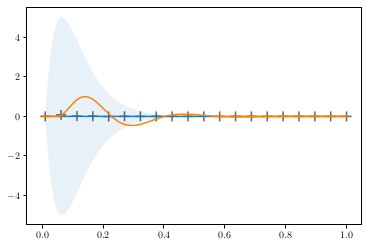

In [ ]:
ipredindenv = AlpEnvelope(iz_vector, itrise, itaudiff, ilag)
index = 0
plt.plot(fpred_points, imeanpred[index])
plt.plot(ftime, ftrue)
is2 = np.sqrt(np.diag(icovpred[index]))
ifill = (imeanpred.flatten() - is2, imeanpred.flatten() + is2)
plt.fill_between(fpred_points.flatten(), *ifill, alpha = 0.1)
plt.scatter(iz_vector, ipredindenv * (icpred @ iv_vector), s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

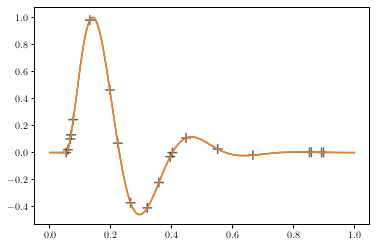

In [ ]:
predindenv = AlpEnvelope(fz_vector, ftrise, ftaudiff, flag)

plt.plot(fpred_points, fmeanpred[index])
plt.plot(ftime, ftrue)
s2 = np.sqrt(np.diag(fcovpred[index]))
fill = (fmeanpred.flatten() - s2, fmeanpred.flatten() + s2)
plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
plt.scatter(fz_vector, predindenv * (fcpred @ fv_vector), s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

In [ ]:
print(xtest.shape)

(1, 2401, 1)


In [ ]:
def OUTconvolve(Filters):
  Pad = np.hstack((Filters, np.zeros((num_filt, k, 1))))
  Pred_fft = np.fft.rfft(Pad, axis = -2)
  Pred_fitfft = np.fft.irfft(Pred_fft * x_fft, n + k + 1, axis = -2)[:, : k + 1]
  
  return np.sum(Pred_fitfft, axis=0)


In [ ]:
is2 = np.sqrt(np.diagonal(icovpred, axis1=1, axis2=2)).reshape((num_filt, n + 1, 1))

imeanpredict = OUTconvolve(imeanpred)
imeanpredictns2 = OUTconvolve(imeanpred - 2 * is2)
imeanpredictps2 = OUTconvolve(imeanpred + 2 * is2)

In [ ]:
fs2 = np.sqrt(np.diagonal(fcovpred, axis1=1, axis2=2)).reshape((num_filt, n + 1, 1))

fmeanpredict = OUTconvolve(fmeanpred)
fmeanpredictns2 = OUTconvolve(fmeanpred - 2 * fs2)
fmeanpredictps2 = OUTconvolve(fmeanpred + 2 * fs2)

In [ ]:
fpad = np.hstack((fmeanpred, np.zeros((num_filt, k, 1))))
fpred_fft = np.fft.rfft(fpad, axis = -2)
fpred_fitfft = np.fft.irfft(fpred_fft * x_fft, n + k + 1, axis = -2)[:, : k + 1]
fmeanpredict = np.sum(fpred_fitfft, axis=0)

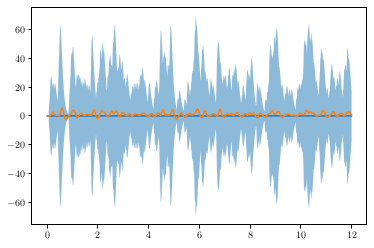

In [ ]:
plt.plot(ytime, imeanpredict)
plt.plot(ytime, ytest.reshape((k + 1, 1)))
plt.fill_between(ytime.flatten(), imeanpredictns2.flatten() - 2 * isigma_n,  
                  imeanpredictps2.flatten() + 2 * isigma_n, alpha = 0.5)

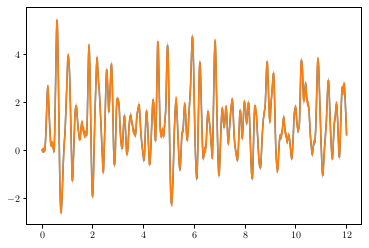

In [ ]:
plt.plot(ytime, fmeanpredict)
plt.plot(ytime, ytest.reshape((k + 1, 1)))
plt.fill_between(ytime.flatten(), fmeanpredictns2.flatten() - 2 * fsigma_n,  
                  fmeanpredictps2.flatten() + 2 * fsigma_n, alpha = 0.5)